In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import zuko
import matplotlib.pyplot as plt

from torch import Tensor
from torch.distributions import Distribution, Normal, Bernoulli, Independent
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from tqdm import tqdm

import IPython

Number of nominal examples: 500
Number of failure examples: 500


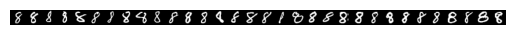

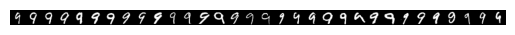

In [3]:
batch_size = 1024
mean = 0.16
std = 0.34
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((mean,), (std,))
    ]
)
trainset = MNIST(root="data/mnist", download=True, train=True, transform=transform)
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Restrict to just 8s and 9s (sorry 9, you're just a failed 8)
labels = trainset.targets
nominal = trainset.data[labels == 8]
failure = trainset.data[labels == 9]

nominal = nominal.float() / 255
failure = failure.float() / 255

# # Normalize
# nominal = (nominal.float() - mean) / std
# failure = (failure.float() - mean) / std

# Reduce the number of failures in the dataset
n_failure = 500
n_nominal = 500
failure = failure[torch.randperm(len(failure))[:n_failure]]
nominal = nominal[torch.randperm(len(nominal))[:n_nominal]]

print(f"Number of nominal examples: {len(nominal)}")
print(f"Number of failure examples: {len(failure)}")

x = [nominal[i] for i in range(min(32, n_failure))]
x = torch.cat(x, dim=-1)
plt.imshow(x, cmap="gray")
plt.axis('off')
plt.show()

x = [failure[i] for i in range(min(32, n_failure))]
x = torch.cat(x, dim=-1)
fig = plt.imshow(x, cmap="gray")
plt.axis('off')
display(fig)

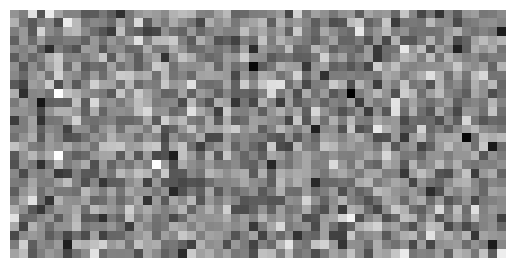

Epoch 34 loss: -1494.890:   7%|▋         | 35/500 [00:12<02:41,  2.88it/s]


KeyboardInterrupt: 

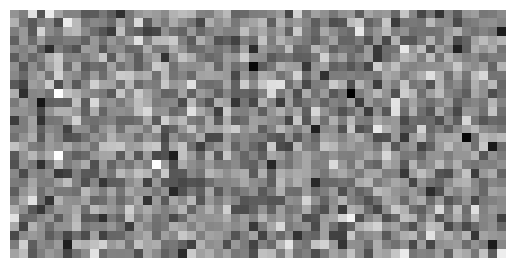

In [4]:
# Define a dead-simple flow
device = torch.device("cuda:3")
flow = zuko.flows.NSF(
    features=28 * 28, context=1, transforms=3, hidden_features=(256, 256)
).to(device)

nominal = nominal.to(device)
failure = failure.to(device)

nominal_label = torch.zeros(1, device=device)
failure_label = torch.ones(1, device=device)

# Maximize the log likelihood of the data
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

# Train the flow
steps = 500
pbar = tqdm(range(steps))
for epoch in pbar:
    optimizer.zero_grad()

    loss = (
        -flow(nominal_label).log_prob(nominal.reshape(-1, 28 * 28)).mean()
        - flow(failure_label).log_prob(failure.reshape(-1, 28 * 28)).mean()
    )

    loss.backward()

    optimizer.step()

    pbar.set_description(f"Epoch {epoch} loss: {loss.detach().item():.3f}")

    if epoch % 100 == 0 or epoch == steps - 1:
        plt.close()
        IPython.display.clear_output(wait=True)
        with torch.no_grad():
            labels = torch.tensor([0, 1]).reshape(-1, 1).to(device)
            images = flow(labels).sample().reshape(-1, 28, 28).cpu()
            image = mean + std * torch.cat([image for image in images], dim=-1)
            plt.imshow(image, cmap="gray")
            plt.axis('off')
            display(plt.gcf())